In [1]:
%matplotlib inline
import numpy as np
import pdb
import matplotlib.pyplot as plt
import glob
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import train_test_split
import sklearn.datasets as datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import copy
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import metrics
import math
np.random.seed(0)

In [2]:
df = pd.read_csv('data.csv')
df.loc[(df['status'] == 'Pass'),'status']=0
df.loc[(df['status'] == 'Killed'),'status']=1
df.loc[(df['status'] == 'Failed'),'status']=1
df['status'].value_counts()
vc_list = {}
unique_vc = df['vc'].unique()
for i in range(15):
    vc_list[unique_vc[i]] = f'vc{i}'
for key,val in vc_list.items():
    df.loc[(df['vc'] == key),'vc']=val
# note: need to add weights for imbalanced data

In [3]:
df.columns

Index(['Unnamed: 0', 'vc', 'jobid', 'num_attempts', 'usr', 'status',
       'num_gpus', 'run_time', 'gpu_util_mean', 'gpu_util_std', 'gpu_util_min',
       'gpu_util_max', 'cpu_util', 'mem_util', 'job_index', 'gpu_mem'],
      dtype='object')

In [4]:
occ_dummies = pd.get_dummies(df['vc'], drop_first=False)
new_df = pd.concat([df.drop('vc', axis=1), occ_dummies], axis=1)
new_df = new_df.drop(columns=['Unnamed: 0', 'jobid', 'usr', 'job_index', 'gpu_mem'])
new_df.columns

Index(['num_attempts', 'status', 'num_gpus', 'run_time', 'gpu_util_mean',
       'gpu_util_std', 'gpu_util_min', 'gpu_util_max', 'cpu_util', 'mem_util',
       'vc0', 'vc1', 'vc10', 'vc11', 'vc12', 'vc13', 'vc14', 'vc2', 'vc3',
       'vc4', 'vc5', 'vc6', 'vc7', 'vc8', 'vc9'],
      dtype='object')

In [5]:
kf = KFold(n_splits=5, shuffle=True)
Y = new_df['status'].to_numpy()
X = new_df.drop(columns=['status']).to_numpy()
# calculate weights
row_num, col_num = X.shape
NaN = np.zeros((row_num,1))
for row in range(row_num):
    check = np.sum(X[row,:])
    has_nan = np.isnan(check)
    if has_nan:
        NaN[row,0] = 1
        for col in range(col_num):
            is_nan = np.isnan(X[row,col])
            if is_nan:
                X[row,col] = 0
    else:
        NaN[row,0] = 1

new_X = np.concatenate((X, NaN), axis=1)
unique, counts = np.unique(Y, return_counts=True)
weights = 1/counts * counts[0] # inversely proportional to number of counts
weight_dict = {0: weights[0], 1: weights[1]}#, 2: weights[2]}

In [6]:
np.unique(X, return_counts=True)

(array([-1.00000000e+00,  0.00000000e+00,  9.61425767e-06, ...,
         8.64576000e+04,  8.64578667e+04,  8.66025167e+04]),
 array([  12767, 1795448,       1, ...,       1,       1,       1]))

train_acc: 86.40508396826995%, test_acc: 85.46430968896846%
train_acc: 85.95195739491379%, test_acc: 84.9228015215932%
train_acc: 85.75280546884615%, test_acc: 84.94517789214589%
train_acc: 85.81769766947494%, test_acc: 84.74379055717162%
train_acc: 85.91631237413291%, test_acc: 85.54421768707483%


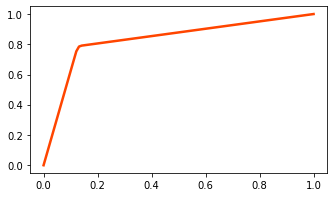

In [10]:
auc_all = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in kf.split(new_X):
    X_train, X_test = new_X[train_index], new_X[test_index]
    y_train, y_test = Y[train_index].astype('int'), Y[test_index].astype('int')
    clf = RandomForestClassifier(criterion='gini', class_weight=weight_dict, max_depth=10, n_jobs=-1, n_estimators=100)
    clf = clf.fit(X_train, y_train)
    predict = clf.predict(X_train)
    train_acc = np.count_nonzero(predict==y_train) / len(y_train) * 100
    predict = clf.predict(X_test)
    val_acc = np.count_nonzero(predict==y_test) / len(y_test) * 100
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predict)
    auc = metrics.auc(fpr, tpr)
    auc_all.append(auc)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    print(f'train_acc: {train_acc}%, test_acc: {val_acc}%')
auc_mean = round(np.mean(auc_all),2)
auc_std = round(np.std(auc_all) / math.sqrt(5),3)
mean_tpr = np.mean(tprs, axis=0)
fig, axs = plt.subplots(1, 1, gridspec_kw={'hspace': 0.1, 'wspace': 0.2, 'bottom': 0.13, 
                                    'top': 0.9, 'right':0.995, 'left':0.17}, figsize=(5,3))
axs.plot(mean_fpr, mean_tpr, 
         label=f'mean:{auc_mean}\n confi. interval: {auc_std}', lw=2.5, color='orangered')

In [8]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(predict, y_test).ravel()
tn, fp, fn, tp

(14628, 1107, 2163, 4446)

In [11]:
axs.set_title('ROC and AUC mean/std (marked in legend)')
axs.grid(which='major', axis='both', ls='dashed', zorder=0)
axs.set_xlabel('FPR')
axs.legend()
# axs[0].set_title('Training Acc.')
# axs[1].set_title('Testing Acc.')
axs.set_ylabel('TPR')
fig.savefig(f'roc_rf.png', bbox_inches='tight')